# CS4287 Assignment02
Kevin Collins 21344256 Olan Healy 21318204 Caoimhe Cahill 21331308

Code Runs without errors? Y

Inspiration: https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=hsHN6_40_L-a


We have all the text blocks down below all the code blocks in order of the spec

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Conv2D, Add, GlobalAveragePooling2D, Dense, Dropout, MaxPooling2D
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

In [ ]:
# Rock Paper Scissors dataset from tensorflow https://www.tensorflow.org/datasets/catalog/rock_paper_scissors
dataset, info = tfds.load('rock_paper_scissors', with_info=True, as_supervised=True) # Loads dataset from TensorFlow Catalog

# Get class labels
class_names = info.features['label'].names
print("Class names:", class_names)
total_examples = info.splits['train'].num_examples
print(f"Total number of examples in the dataset: {total_examples}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2520 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.W0QD5Z_3.0.0/rock_paper_scissors-train.tfre…

Generating test examples...:   0%|          | 0/372 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/rock_paper_scissors/incomplete.W0QD5Z_3.0.0/rock_paper_scissors-test.tfrec…

Dataset rock_paper_scissors downloaded and prepared to /root/tensorflow_datasets/rock_paper_scissors/3.0.0. Subsequent calls will reuse this data.
Class names: ['rock', 'paper', 'scissors']
Total number of examples in the dataset: 2520


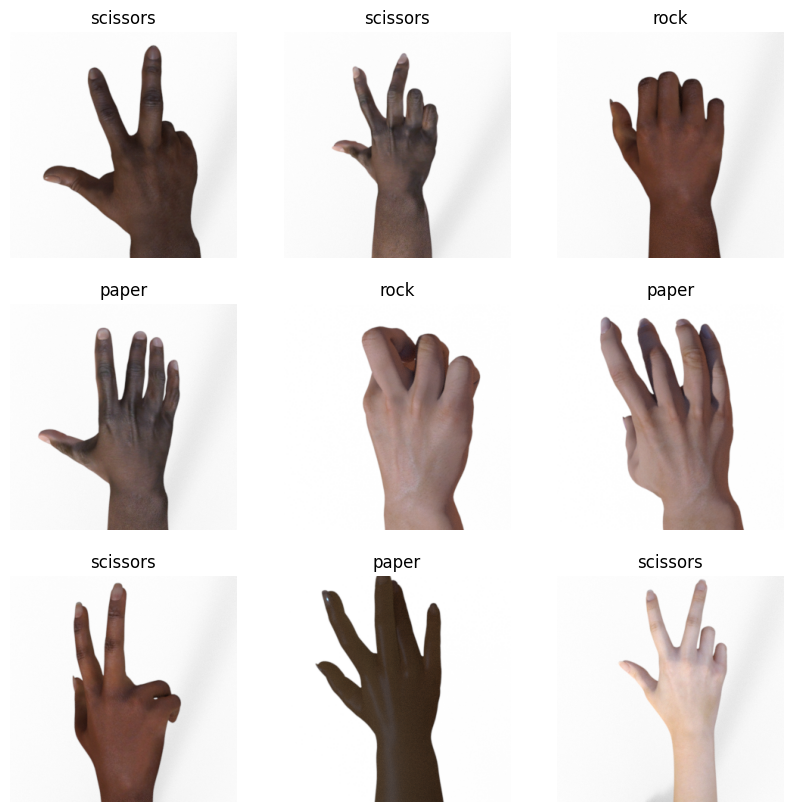

In [ ]:
# Function to plot first 9 images with their label from the dataset to show off what some of data looks like
def plot_sample_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image)
        plt.title(class_names[label.numpy()])
        plt.axis('off')
    plt.show()

plot_sample_images(dataset['train'], class_names)

<ipython-input-4-622826eca000>:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=counts, palette='coolwarm')


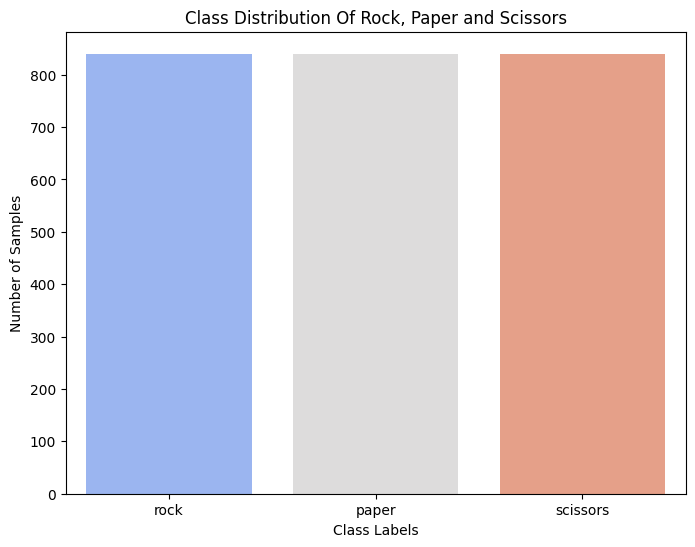

In [ ]:
# Function to count class distribution between rock, paper and scissors
def get_class_distribution(dataset):
    class_counts = {0: 0, 1: 0, 2: 0}  # Set rock to 0, paper to 1, scissors to 2
    for image, label in dataset:  # Go over the whole dataset and count each label
        class_counts[label.numpy()] += 1
    return class_counts

# Get the class distribution for the entire dataset ( dataset is called train we wont use their train / test split we will make our test ourselves)
class_dist = get_class_distribution(dataset['train'])

# Convert class indices to names
class_dist_named = {class_names[key]: value for key, value in class_dist.items()}

# function to plot this class distributuion
def plot_class_distribution(class_dist_named):
    labels = list(class_dist_named.keys())
    counts = list(class_dist_named.values())

    plt.figure(figsize=(8, 6))
    sns.barplot(x=labels, y=counts, palette='coolwarm')
    plt.title('Class Distribution Of Rock, Paper and Scissors')
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Samples')
    plt.show()

# call function to plot this distriubution, which is even between all
plot_class_distribution(class_dist_named)

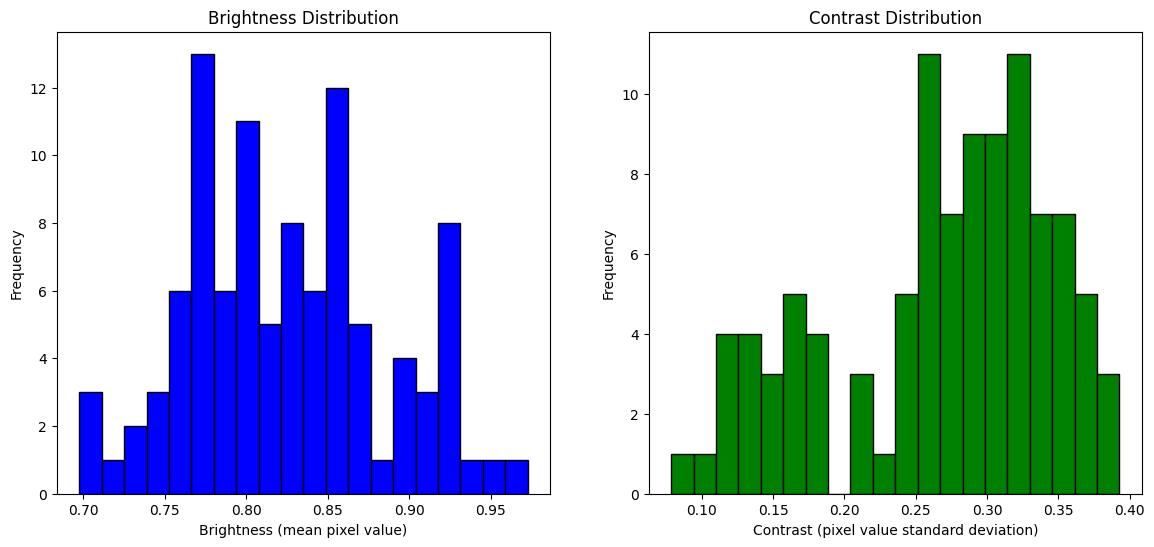

In [ ]:
# Function to compute brightness and contrast for an image
def compute_brightness_contrast(image):
    brightness = np.mean(image)  # Brightness is the mean pixel value
    contrast = np.std(image)  # Contrast is the standard deviation of pixel values
    return brightness, contrast

# Function to compute brightness and contrast for the dataset, we will take 100 samples
def compute_brightness_contrast_dataset(dataset, num_samples=100):
    brightness_list = []
    contrast_list = []

    # take the 100 samples from dataset
    for image, _ in dataset.take(num_samples):
        image = image.numpy() / 255.0
        brightness, contrast = compute_brightness_contrast(image)
        brightness_list.append(brightness)
        contrast_list.append(contrast)

    return brightness_list, contrast_list

# Plot brightness and contrast distributions
def plot_brightness_contrast_distributions(brightness_list, contrast_list):
    plt.figure(figsize=(14, 6))

    # Brightness Distribution
    plt.subplot(1, 2, 1)
    plt.hist(brightness_list, bins=20, color='blue', edgecolor='black')
    plt.title("Brightness Distribution")
    plt.xlabel("Brightness (mean pixel value)")
    plt.ylabel("Frequency")

    # Contrast Distribution
    plt.subplot(1, 2, 2)
    plt.hist(contrast_list, bins=20, color='green', edgecolor='black')
    plt.title("Contrast Distribution")
    plt.xlabel("Contrast (pixel value standard deviation)")
    plt.ylabel("Frequency")

    plt.show()

# Take the samples from the dataset
brightness_list, contrast_list = compute_brightness_contrast_dataset(dataset['train'])

# Plot brightness and contrast of these samples
plot_brightness_contrast_distributions(brightness_list, contrast_list)

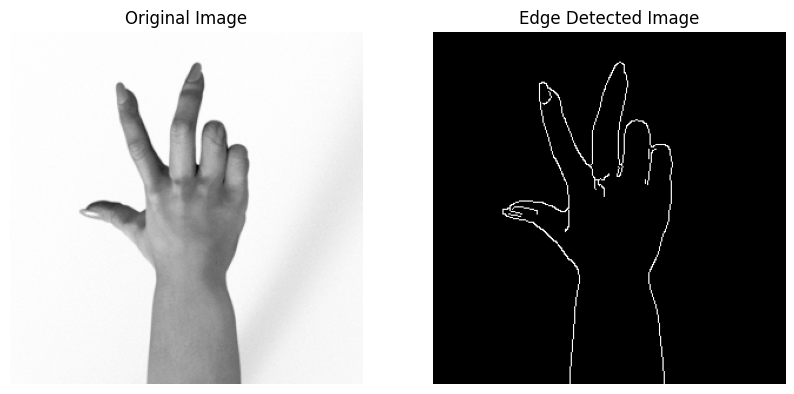

In [ ]:
# Function to visualise edges using open cv
def visualise_edges(dataset, buffer_size=1000):
    # Take random image from the dataset
    sample_image, sample_label = next(iter(dataset['train'].shuffle(buffer_size=buffer_size).take(1)))

    # Convert the image to numpy as opencv needs to have
    image_np = sample_image.numpy()

    # Convert to greyscale so canny detection can work
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)


    # use edge detection on the image
    edges = cv2.Canny(image_gray, threshold1=100, threshold2=200)

    # Plot original image (greyscaled) and dedge detected image
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image_gray, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detected Image')
    plt.axis('off')

    plt.show()

# Call it on dataset, will do random image each time
visualise_edges(dataset)

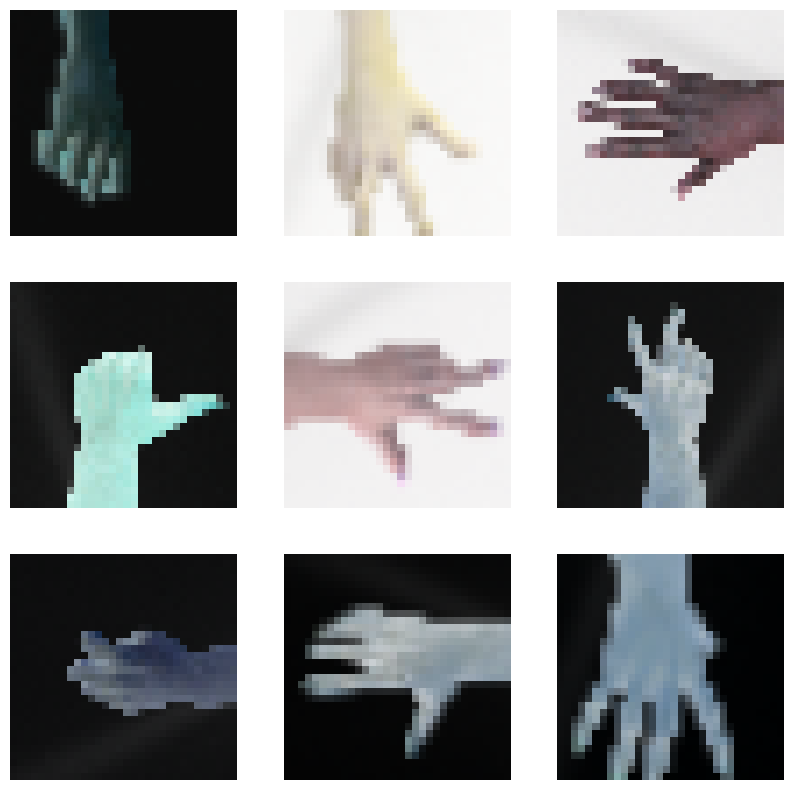

In [ ]:
# Setting dimensions for images
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)  # Using RGB images as input, 32x32 pixels

# Define the preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (img_rows, img_cols))
    image = image / 255.0
    return image, label

# All augmentations got from here https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=3CikvwUBwUVZ
# Augmentation to flip
def augment_flip(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    return image

# Augmentation for colour
def augment_color(image: tf.Tensor) -> tf.Tensor:
    image = tf.image.random_hue(image, max_delta=0.08)
    image = tf.image.random_saturation(image, lower=0.7, upper=1.3)
    image = tf.image.random_brightness(image, 0.05)
    image = tf.image.random_contrast(image, lower=0.8, upper=1)
    image = tf.clip_by_value(image, clip_value_min=0, clip_value_max=1)
    return image

# Rotation augmentation
def augment_rotation(image: tf.Tensor) -> tf.Tensor:
    # Rotate 0, 90, 180, 270 degrees
    return tf.image.rot90(
        image,
        tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    )

# Augmentation for inversing
def augment_inversion(image: tf.Tensor) -> tf.Tensor:
    random = tf.random.uniform(shape=[], minval=0, maxval=1)
    if random > 0.5:
        image = tf.math.multiply(image, -1)
        image = tf.math.add(image, 1)
    return image

# Augmentation for zoom
def augment_zoom(image: tf.Tensor, min_zoom=0.8, max_zoom=1.0) -> tf.Tensor:
    image_width, image_height, _ = image.shape
    crop_size = (image_width, image_height)

    # Generate crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(min_zoom, max_zoom, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize(
            [img],
            boxes=boxes,
            box_indices=np.zeros(len(scales)),
            crop_size=crop_size
        )
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: image, lambda: random_crop(image))

# Combine the augmentation functions
def augment_data(image, label):
    image = augment_flip(image)
    image = augment_color(image)
    image = augment_rotation(image)
    image = augment_zoom(image)
    image = augment_inversion(image)
    return image, label

# Splitting the dataset into training and test sets
train_size= int(0.8 * dataset['train'].cardinality().numpy())

# Apply augmentations only to training data as need to keep test part as real representation of dataset, also use our preprocessing function on it
train_dataset = (
    dataset['train'].take(train_size)
    .map(preprocess)
    .map(augment_data)
    .batch(32)
    .shuffle(buffer_size=1000)
)

test_dataset = (
    dataset['train'].skip(train_size)
    .map(preprocess)
    .batch(32)
)

# Preview some augmented images
def preview_dataset(dataset, num_images=9):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 10))
    for i, (image, _) in enumerate(dataset.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(tf.squeeze(image))
        plt.axis('off')
    plt.show()

# Preview augmented images from the training dataset
preview_dataset(train_dataset.unbatch())

In [ ]:
# HyperParameters
num_classes = 3
LEARNING_RATE = 0.001
DROPOUT_RATE = 0.5
BATCH_NORM = True
EPOCHS = 100

In [ ]:
# Function to build ResNet model
def build_resnet(input_shape, num_classes, dropout_rate, batch_norm):
    # Define the input layer to be shape of image (32,32,3)
    inputs = layers.Input(shape=input_shape)

    # Initial Convolutional Block, Two Conv2d layers with 32 filters of size (3,3)
    # padding same makes it so output dimensions are same as input and use relu as activation
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    #  MaxPooling reduces the spatial dimensions to help ddecrease computation
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)

    # Residual Blocks (2 of them)
    for _ in range(2):
        residual = x  # Save current feature maps as the residual connection
         # Apply two more Conv2D layers to transform the feature map
        x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        # Add the residual connection to the output of the layers above
        x = layers.Add()([x, residual])
        # use Relu again to combined output
        x = layers.Activation('relu')(x)

    # Global average pooling helps prevent overfitting as reduces each feature map to single value by computing average
    x = layers.GlobalAveragePooling2D()(x)

    # appply dropout with rate of 0.5 to reduce overfitting
    x = layers.Dropout(dropout_rate)(x)
    if batch_norm:
      #  batch normalisation to speed up and stablise training
        x = layers.BatchNormalization()(x)

    # Dnese layer as Output with our number of classes (3) and using softmax activation to output a probability distribution over the classes
    predictions = layers.Dense(num_classes, activation='softmax')(x)

    # Create model
    model = models.Model(inputs=inputs, outputs=predictions, name='ResNet')

    return model


In [ ]:
def train_and_evaluate_model(model, train_dataset, test_dataset, learning_rate, epochs):
    # Compile the Model
    model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Print Model Summary
    model.summary()

    # Train the Model
    history = model.fit(train_dataset,
                        validation_data=test_dataset,
                        epochs=epochs)

    # Plot accuracy and loss over epochs
    plot_training_history(history)

    return model, history

def plot_training_history(history):
    acc = history.history['accuracy']
    test_acc = history.history['val_accuracy']
    loss = history.history['loss']
    test_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))

    # Plot training & test accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, test_acc, label='Test Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Test Accuracy')

    # Plot training & test loss values
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, test_loss, label='Test Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Test Loss')

    plt.show()


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 32)     │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 16, 16, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16, 16, 32)     │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 16, 32)     │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32)             │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │             99 │ batch_normalization[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 47,363 (185.01 KB)

 Trainable params: 47,299 (184.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 182ms/step - accuracy: 0.3619 - loss: 1.3258 - val_accuracy: 0.3115 - val_loss: 1.0977
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - accuracy: 0.3794 - loss: 1.1037 - val_accuracy: 0.3492 - val_loss: 1.0948
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 163ms/step - accuracy: 0.3963 - loss: 1.0757 - val_accuracy: 0.3115 - val_loss: 1.0908
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.4123 - loss: 1.0483 - val_accuracy: 0.4048 - val_loss: 1.0046
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 174ms/step - accuracy: 0.5771 - loss: 0.8765 - val_accuracy: 0.3175 - val_loss: 1.1301
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 169ms/step - accuracy: 0.6327 - loss: 0.7520 - val_accuracy: 0.7837 - val_loss: 0.7275
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.6851 - loss: 0.6935 - val_accuracy: 0.7282 - val_loss: 0.7392
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 174ms/step - accuracy: 0.6920 - loss: 0.6958 - 

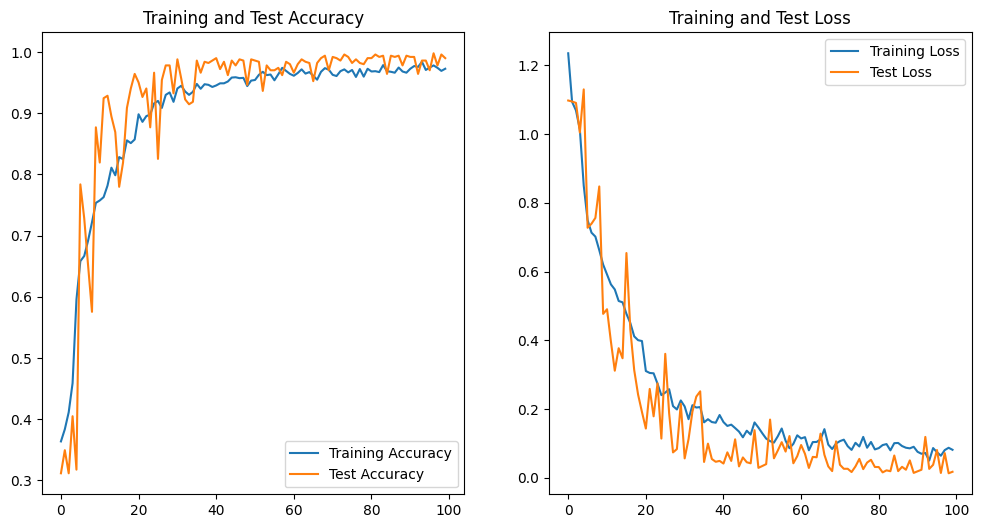

In [ ]:
# Build the ResNet model
resnet_model = build_resnet(input_shape, num_classes, DROPOUT_RATE, BATCH_NORM)

# Train and evaluate the ResNet model
model, history = train_and_evaluate_model(
    resnet_model,
    train_dataset,
    test_dataset,
    LEARNING_RATE,
    EPOCHS)

In [ ]:
# Function to build VGG model
def build_vgg(input_shape, num_classes, dropout_rate, batch_norm):
    inputs = layers.Input(shape=input_shape)

    # Convolutional Layers - 32 filters, 3x3 filters, same padding
    # Max Pooling layer - 2x2 pool size
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Layers - 64 filters, 3x3 filters, same padding
    # Max Pooling layer - 2x2 pool size
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Convolutional Layers - 128 filters, 3x3 filters, same padding
    # Max Pooling layer - 2x2 pool size
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Flatten and Fully Connected Layers
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(dropout_rate)(x)
    if batch_norm:
        x = layers.BatchNormalization()(x)

    # Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs, name='VGG')
    return model


Model: "VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_61 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_62 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_63 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_64 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_65 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,179 (2.10 MB)

 Trainable params: 549,923 (2.10 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.3576 - loss: 1.1626 - val_accuracy: 0.5873 - val_loss: 1.0676
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 255ms/step - accuracy: 0.6398 - loss: 0.7997 - val_accuracy: 0.7242 - val_loss: 0.8976
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.7408 - loss: 0.5959 - val_accuracy: 0.8095 - val_loss: 0.5954
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 254ms/step - accuracy: 0.8524 - loss: 0.3957 - val_accuracy: 0.8056 - val_loss: 0.4641
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.8772 - loss: 0.3155 - val_accuracy: 0.7817 - val_loss: 0.4814
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.9115 - loss: 0.2509 - val_accuracy: 0.9266 - val_loss: 0.2228
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 280ms/step - accuracy: 0.9396 - loss: 0.2102 - val_accuracy: 0.9921 - val_loss: 0.0727
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9429 - loss: 0.1842 - 

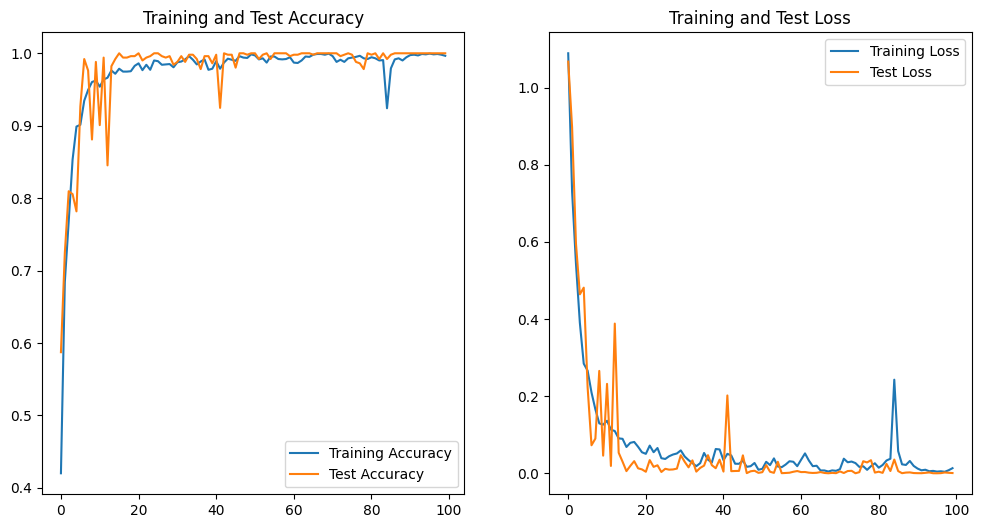

In [ ]:
# Build the VGG model
vgg_model = build_vgg(input_shape, num_classes, DROPOUT_RATE, BATCH_NORM)

# Train and evaluate the VGG model
model_vgg, history_vgg = train_and_evaluate_model(
    vgg_model,
    train_dataset,
    test_dataset,
    LEARNING_RATE,
    EPOCHS
)


=== Training RESNET Model ===

Training fold 1...


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_66 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_11[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_67 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_66[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_23          │ (None, 16, 16, 32)     │              0 │ conv2d_67[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_68 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_69 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_68[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_10 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_69[0][0],       │
│                           │                        │                │ max_pooling2d_23[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_10             │ (None, 16, 16, 32)     │              0 │ add_10[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_70 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_71 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_70[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_11 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_71[0][0],       │
│                           │                        │                │ activation_10[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_11             │ (None, 16, 16, 32)     │              0 │ add_11[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ activation_11[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_12 (Dropout)      │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32)             │            128 │ dropout_12[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)     

 Total params: 47,363 (185.01 KB)

 Trainable params: 47,299 (184.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 35s 192ms/step - accuracy: 0.3412 - loss: 1.3753 - val_accuracy: 0.4286 - val_loss: 1.0979
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.3596 - loss: 1.1475 - val_accuracy: 0.3393 - val_loss: 1.0948
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 189ms/step - accuracy: 0.3998 - loss: 1.0985 - val_accuracy: 0.3611 - val_loss: 1.0788
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.5103 - loss: 0.9713 - val_accuracy: 0.3988 - val_loss: 0.9847
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.6180 - loss: 0.8133 - val_accuracy: 0.3115 - val_loss: 1.4459
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 188ms/step - accuracy: 0.6459 - loss: 0.7602 - val_accuracy: 0.5972 - val_loss: 0.7763
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 190ms/step - accuracy: 0.7217 - loss: 0.6444 - val_accuracy: 0.8909 - val_loss: 0.5560
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 177ms/step - accuracy: 0.7746 - loss: 0.5660 - val_accu

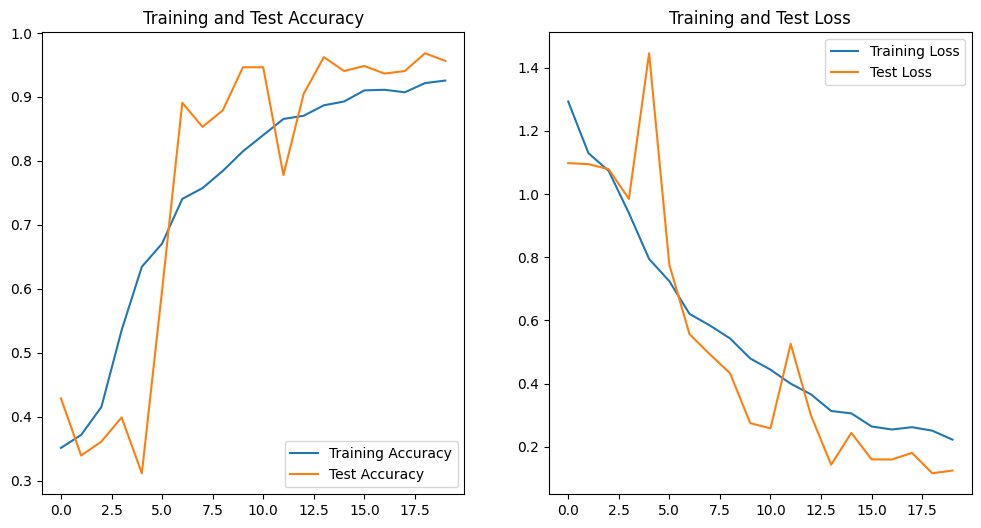

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.9565 - loss: 0.1304
Accuracy for fold 1: 0.9563491940498352
Training fold 2...


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_72 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_73 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_72[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_24          │ (None, 16, 16, 32)     │              0 │ conv2d_73[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_74 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_75 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_74[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_75[0][0],       │
│                           │                        │                │ max_pooling2d_24[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_12             │ (None, 16, 16, 32)     │              0 │ add_12[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_76 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_77 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_76[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_13 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_77[0][0],       │
│                           │                        │                │ activation_12[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_13             │ (None, 16, 16, 32)     │              0 │ add_13[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ activation_13[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_13 (Dropout)      │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 32)             │            128 │ dropout_13[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)     

 Total params: 47,363 (185.01 KB)

 Trainable params: 47,299 (184.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.3421 - loss: 1.3129 - val_accuracy: 0.3393 - val_loss: 1.1001
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 178ms/step - accuracy: 0.3932 - loss: 1.1204 - val_accuracy: 0.3115 - val_loss: 1.0956
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 171ms/step - accuracy: 0.4456 - loss: 1.0516 - val_accuracy: 0.4444 - val_loss: 1.0789
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 195ms/step - accuracy: 0.5013 - loss: 0.9763 - val_accuracy: 0.3829 - val_loss: 0.9965
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 195ms/step - accuracy: 0.6076 - loss: 0.8362 - val_accuracy: 0.4345 - val_loss: 0.8936
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 193ms/step - accuracy: 0.6448 - loss: 0.7912 - val_accuracy: 0.8036 - val_loss: 0.7391
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 177ms/step - accuracy: 0.7141 - loss: 0.6826 - val_accuracy: 0.7202 - val_loss: 0.6641
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 197ms/step - accuracy: 0.7250 - loss: 0.6413 - val_accu

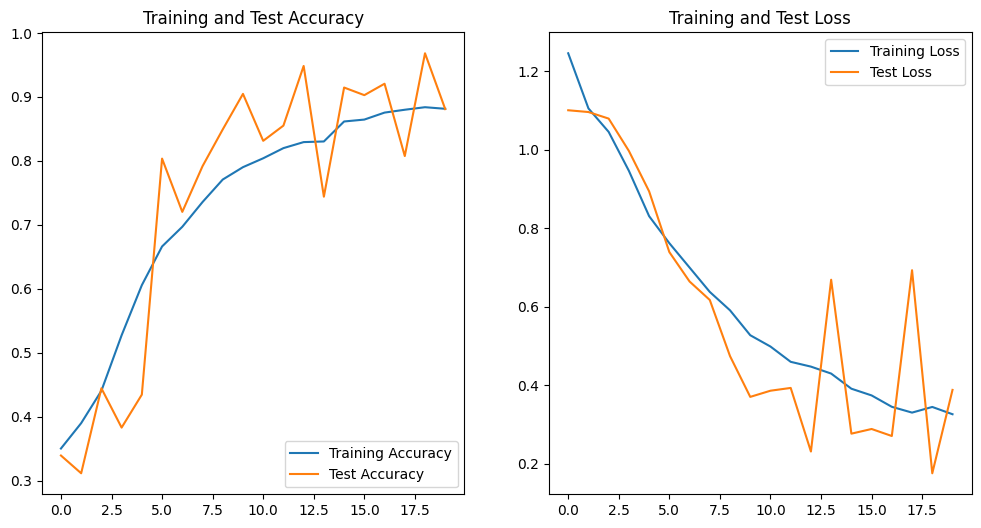

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8723 - loss: 0.4122
Accuracy for fold 2: 0.8809523582458496
Training fold 3...


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_78 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_79 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_78[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_25          │ (None, 16, 16, 32)     │              0 │ conv2d_79[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_80 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_81 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_80[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_14 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_81[0][0],       │
│                           │                        │                │ max_pooling2d_25[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_14             │ (None, 16, 16, 32)     │              0 │ add_14[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_82 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ activation_14[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_83 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_82[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_15 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_83[0][0],       │
│                           │                        │                │ activation_14[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_15             │ (None, 16, 16, 32)     │              0 │ add_15[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ activation_15[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_14 (Dropout)      │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 32)             │            128 │ dropout_14[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)     

 Total params: 47,363 (185.01 KB)

 Trainable params: 47,299 (184.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 183ms/step - accuracy: 0.3737 - loss: 1.2449 - val_accuracy: 0.3770 - val_loss: 1.0936
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 163ms/step - accuracy: 0.4799 - loss: 1.0081 - val_accuracy: 0.5179 - val_loss: 1.0447
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.6135 - loss: 0.8143 - val_accuracy: 0.3929 - val_loss: 0.9243
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 173ms/step - accuracy: 0.6667 - loss: 0.7406 - val_accuracy: 0.4087 - val_loss: 0.8431
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 196ms/step - accuracy: 0.7042 - loss: 0.6741 - val_accuracy: 0.7183 - val_loss: 0.6713
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - accuracy: 0.7456 - loss: 0.6121 - val_accuracy: 0.6349 - val_loss: 0.7167
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 184ms/step - accuracy: 0.7670 - loss: 0.5808 - val_accuracy: 0.8413 - val_loss: 0.4946
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 175ms/step - accuracy: 0.7854 - loss: 0.5567 - val_accu

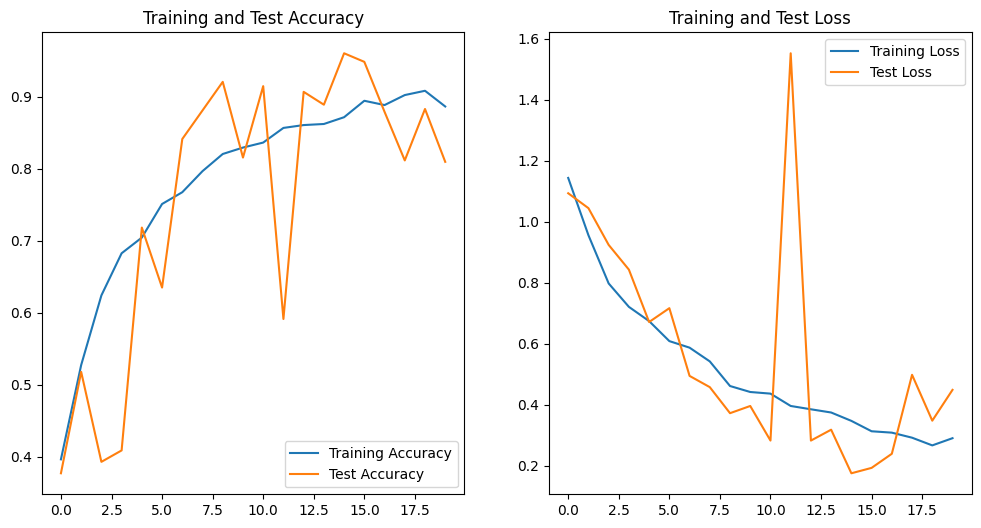

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8282 - loss: 0.4299
Accuracy for fold 3: 0.8095238208770752
Training fold 4...


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_84 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_85 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_84[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_26          │ (None, 16, 16, 32)     │              0 │ conv2d_85[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_86 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_87 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_86[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_87[0][0],       │
│                           │                        │                │ max_pooling2d_26[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_16             │ (None, 16, 16, 32)     │              0 │ add_16[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_88 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_89 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_88[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_17 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_89[0][0],       │
│                           │                        │                │ activation_16[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_17             │ (None, 16, 16, 32)     │              0 │ add_17[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ activation_17[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_15 (Dropout)      │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_14    │ (None, 32)             │            128 │ dropout_15[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)     

 Total params: 47,363 (185.01 KB)

 Trainable params: 47,299 (184.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 17s 200ms/step - accuracy: 0.3220 - loss: 1.3876 - val_accuracy: 0.3393 - val_loss: 1.1262
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 187ms/step - accuracy: 0.3149 - loss: 1.1930 - val_accuracy: 0.3115 - val_loss: 1.1030
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.3574 - loss: 1.1185 - val_accuracy: 0.3393 - val_loss: 1.0957
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 176ms/step - accuracy: 0.3734 - loss: 1.0962 - val_accuracy: 0.3393 - val_loss: 1.0942
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 197ms/step - accuracy: 0.4066 - loss: 1.0734 - val_accuracy: 0.4583 - val_loss: 1.0867
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.4618 - loss: 1.0422 - val_accuracy: 0.3552 - val_loss: 1.0553
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 194ms/step - accuracy: 0.4873 - loss: 0.9940 - val_accuracy: 0.5437 - val_loss: 0.8837
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.6079 - loss: 0.8422 - val_accu

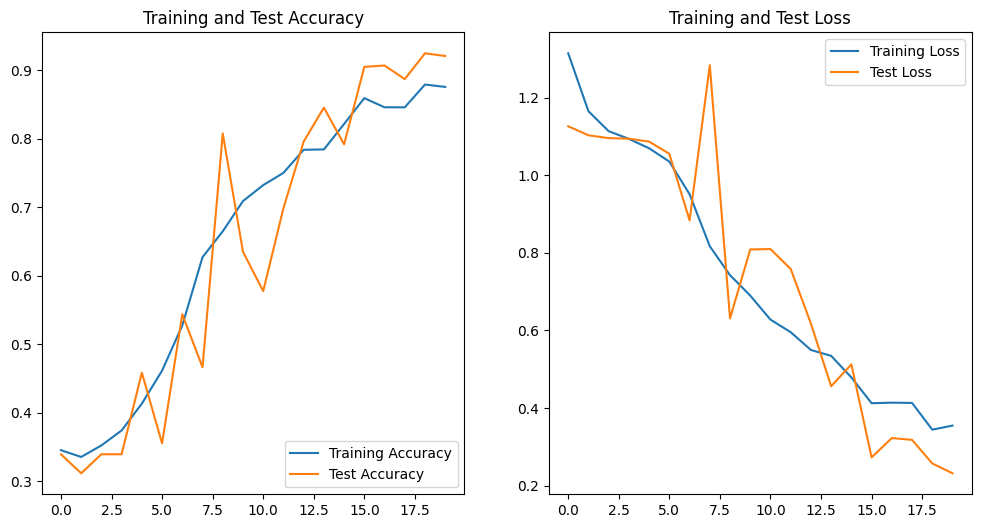

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.9155 - loss: 0.2395
Accuracy for fold 4: 0.920634925365448
Training fold 5...


Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_15            │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_90 (Conv2D)        │ (None, 32, 32, 32)     │            896 │ input_layer_15[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_91 (Conv2D)        │ (None, 32, 32, 32)     │          9,248 │ conv2d_90[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_27          │ (None, 16, 16, 32)     │              0 │ conv2d_91[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_92 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_93 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_92[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_18 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_93[0][0],       │
│                           │                        │                │ max_pooling2d_27[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_18             │ (None, 16, 16, 32)     │              0 │ add_18[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, 16, 16, 32)     │          9,248 │ conv2d_94[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_19 (Add)              │ (None, 16, 16, 32)     │              0 │ conv2d_95[0][0],       │
│                           │                        │                │ activation_18[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_19             │ (None, 16, 16, 32)     │              0 │ add_19[0][0]           │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 32)             │              0 │ activation_19[0][0]    │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_16 (Dropout)      │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 32)             │            128 │ dropout_16[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)     

 Total params: 47,363 (185.01 KB)

 Trainable params: 47,299 (184.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - accuracy: 0.3226 - loss: 1.3165 - val_accuracy: 0.3393 - val_loss: 1.1012
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 189ms/step - accuracy: 0.3885 - loss: 1.0997 - val_accuracy: 0.3115 - val_loss: 1.1006
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.3935 - loss: 1.0731 - val_accuracy: 0.3115 - val_loss: 1.0699
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 168ms/step - accuracy: 0.5197 - loss: 0.9475 - val_accuracy: 0.6012 - val_loss: 1.0040
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 192ms/step - accuracy: 0.6058 - loss: 0.8286 - val_accuracy: 0.5516 - val_loss: 0.8181
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 185ms/step - accuracy: 0.6838 - loss: 0.7244 - val_accuracy: 0.7480 - val_loss: 0.6111
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 190ms/step - accuracy: 0.7200 - loss: 0.6545 - val_accuracy: 0.7421 - val_loss: 0.6985
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 194ms/step - accuracy: 0.7565 - loss: 0.5931 - val_accu

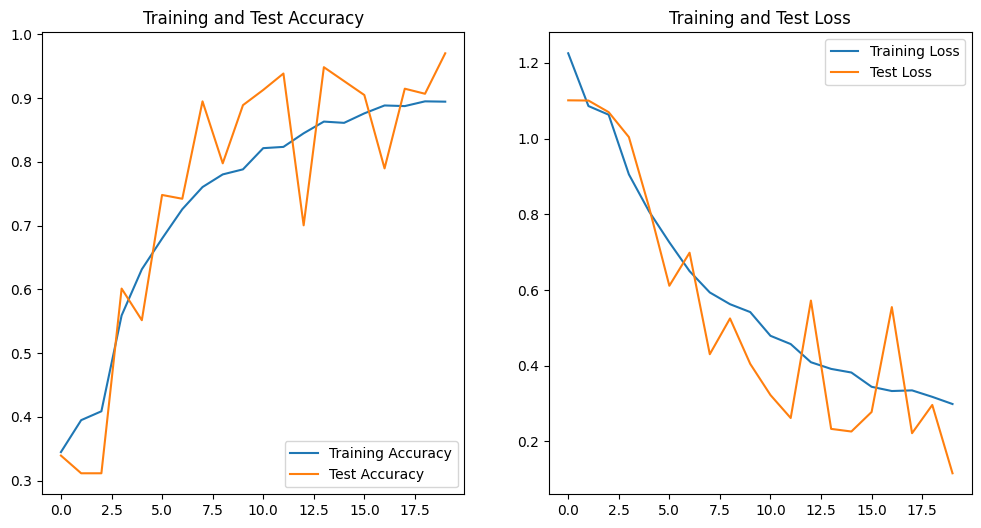

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.9666 - loss: 0.1226
Accuracy for fold 5: 0.9702380895614624

Average accuracy for RESNET across 5 folds: 0.907539677619934


=== Training VGG Model ===

Training fold 1...


Model: "VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_96 (Conv2D)                   │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_97 (Conv2D)                   │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_98 (Conv2D)                   │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_99 (Conv2D)                   │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_29 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_100 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_101 (Conv2D)                  │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_30 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_6 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,179 (2.10 MB)

 Trainable params: 549,923 (2.10 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.3406 - loss: 1.3122 - val_accuracy: 0.3095 - val_loss: 1.1641
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 262ms/step - accuracy: 0.3547 - loss: 1.2037 - val_accuracy: 0.5853 - val_loss: 1.0261
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 264ms/step - accuracy: 0.5681 - loss: 0.8928 - val_accuracy: 0.8214 - val_loss: 0.8090
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 263ms/step - accuracy: 0.7506 - loss: 0.6371 - val_accuracy: 0.8512 - val_loss: 0.5436
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.8219 - loss: 0.4828 - val_accuracy: 0.8532 - val_loss: 0.4286
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 282ms/step - accuracy: 0.8368 - loss: 0.4442 - val_accuracy: 0.8968 - val_loss: 0.3993
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 260ms/step - accuracy: 0.8940 - loss: 0.3017 - val_accuracy: 0.9544 - val_loss: 0.2149
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.9070 - loss: 0.2565 - val_accu

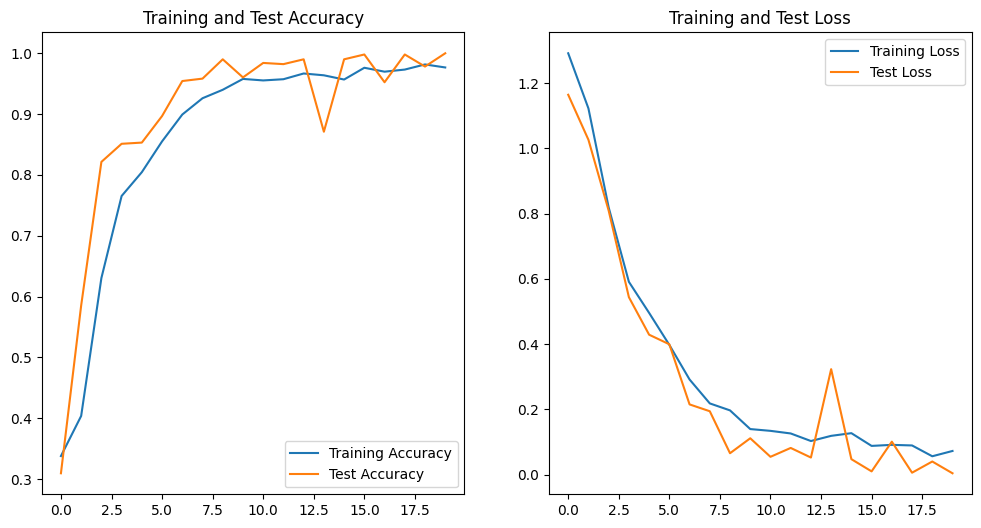

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 1.0000 - loss: 0.0039
Accuracy for fold 1: 1.0
Training fold 2...


Model: "VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_102 (Conv2D)                  │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_103 (Conv2D)                  │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_31 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_104 (Conv2D)                  │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_105 (Conv2D)                  │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_32 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_106 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_107 (Conv2D)                  │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_33 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,179 (2.10 MB)

 Trainable params: 549,923 (2.10 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 285ms/step - accuracy: 0.3398 - loss: 1.2533 - val_accuracy: 0.3492 - val_loss: 1.2227
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - accuracy: 0.3637 - loss: 1.1709 - val_accuracy: 0.3849 - val_loss: 1.0552
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.5343 - loss: 0.9373 - val_accuracy: 0.6746 - val_loss: 0.8116
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.6942 - loss: 0.7167 - val_accuracy: 0.7877 - val_loss: 0.5758
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 266ms/step - accuracy: 0.7706 - loss: 0.5623 - val_accuracy: 0.8512 - val_loss: 0.3573
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 281ms/step - accuracy: 0.8575 - loss: 0.4159 - val_accuracy: 0.9286 - val_loss: 0.2184
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 304ms/step - accuracy: 0.8892 - loss: 0.3283 - val_accuracy: 0.9345 - val_loss: 0.1794
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 268ms/step - accuracy: 0.9198 - loss: 0.2496 - val_accu

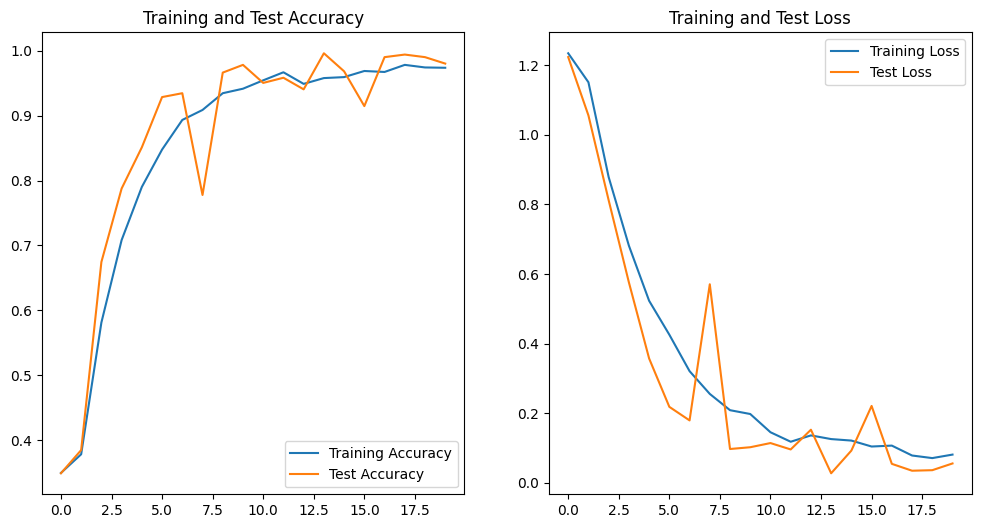

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9877 - loss: 0.0437
Accuracy for fold 2: 0.9801587462425232
Training fold 3...


Model: "VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_108 (Conv2D)                  │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_109 (Conv2D)                  │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_34 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_110 (Conv2D)                  │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_111 (Conv2D)                  │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_35 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_112 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_113 (Conv2D)                  │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_36 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_8 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,179 (2.10 MB)

 Trainable params: 549,923 (2.10 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 265ms/step - accuracy: 0.3660 - loss: 1.2451 - val_accuracy: 0.3115 - val_loss: 1.0855
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 306ms/step - accuracy: 0.6147 - loss: 0.8330 - val_accuracy: 0.7798 - val_loss: 0.7943
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 264ms/step - accuracy: 0.8068 - loss: 0.5080 - val_accuracy: 0.7937 - val_loss: 0.5673
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 0.8728 - loss: 0.3443 - val_accuracy: 0.9563 - val_loss: 0.2555
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 278ms/step - accuracy: 0.9254 - loss: 0.2285 - val_accuracy: 0.9325 - val_loss: 0.1962
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 264ms/step - accuracy: 0.9264 - loss: 0.2358 - val_accuracy: 0.9702 - val_loss: 0.1091
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 271ms/step - accuracy: 0.9478 - loss: 0.1622 - val_accuracy: 0.9802 - val_loss: 0.0713
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 273ms/step - accuracy: 0.9664 - loss: 0.1164 - val_accu

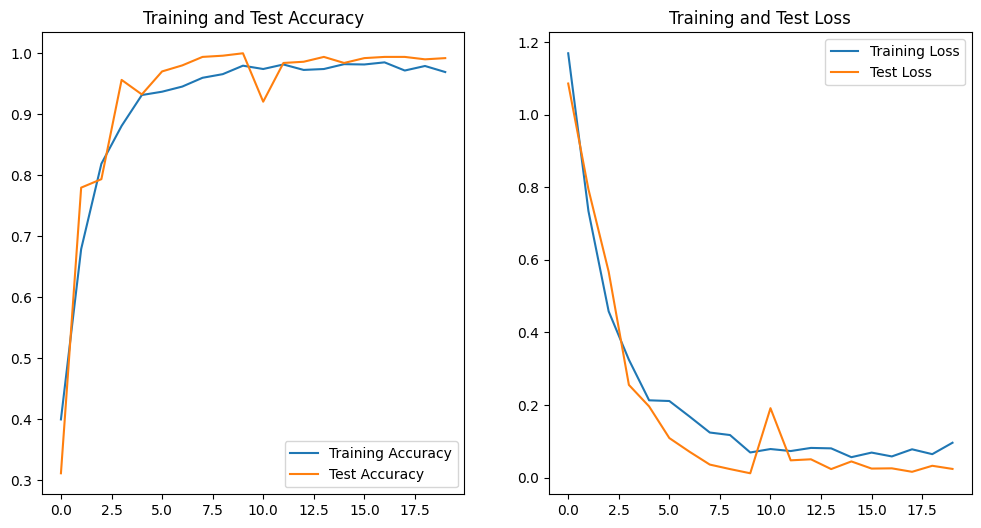

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9919 - loss: 0.0239
Accuracy for fold 3: 0.9920634627342224
Training fold 4...


Model: "VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_19 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_114 (Conv2D)                  │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_115 (Conv2D)                  │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_37 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_116 (Conv2D)                  │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_117 (Conv2D)                  │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_38 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_118 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_119 (Conv2D)                  │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_39 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_9 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,179 (2.10 MB)

 Trainable params: 549,923 (2.10 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 24s 315ms/step - accuracy: 0.3436 - loss: 1.2896 - val_accuracy: 0.3115 - val_loss: 1.2687
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 41s 307ms/step - accuracy: 0.4167 - loss: 1.1218 - val_accuracy: 0.3393 - val_loss: 1.0117
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 296ms/step - accuracy: 0.6807 - loss: 0.7288 - val_accuracy: 0.7937 - val_loss: 0.6842
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 267ms/step - accuracy: 0.8193 - loss: 0.5108 - val_accuracy: 0.7599 - val_loss: 0.5026
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 269ms/step - accuracy: 0.8977 - loss: 0.3136 - val_accuracy: 0.7143 - val_loss: 0.5559
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 273ms/step - accuracy: 0.9314 - loss: 0.2295 - val_accuracy: 0.9623 - val_loss: 0.1257
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 270ms/step - accuracy: 0.9342 - loss: 0.2368 - val_accuracy: 0.9663 - val_loss: 0.1011
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 287ms/step - accuracy: 0.9520 - loss: 0.1493 - val_accu

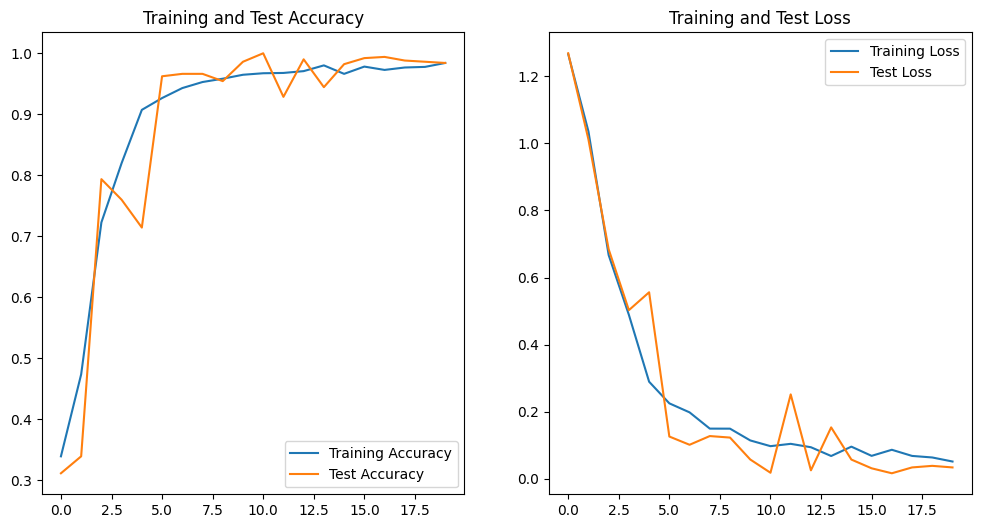

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9807 - loss: 0.0397
Accuracy for fold 4: 0.9841269850730896
Training fold 5...


Model: "VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)          │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_120 (Conv2D)                  │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_121 (Conv2D)                  │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_40 (MaxPooling2D)      │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_122 (Conv2D)                  │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_123 (Conv2D)                  │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_41 (MaxPooling2D)      │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_124 (Conv2D)                  │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_125 (Conv2D)                  │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_42 (MaxPooling2D)      │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 550,179 (2.10 MB)

 Trainable params: 549,923 (2.10 MB)

 Non-trainable params: 256 (1.00 KB)

Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 22s 274ms/step - accuracy: 0.3492 - loss: 1.2693 - val_accuracy: 0.3115 - val_loss: 1.1410
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 271ms/step - accuracy: 0.3433 - loss: 1.2023 - val_accuracy: 0.3492 - val_loss: 1.1038
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 309ms/step - accuracy: 0.4535 - loss: 1.0412 - val_accuracy: 0.5794 - val_loss: 0.9747
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 40s 288ms/step - accuracy: 0.7555 - loss: 0.6309 - val_accuracy: 0.7460 - val_loss: 0.6862
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 271ms/step - accuracy: 0.8234 - loss: 0.4841 - val_accuracy: 0.7004 - val_loss: 0.5761
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 262ms/step - accuracy: 0.9144 - loss: 0.2937 - val_accuracy: 0.8611 - val_loss: 0.4367
Epoch 7/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 291ms/step - accuracy: 0.9241 - loss: 0.2434 - val_accuracy: 0.9802 - val_loss: 0.1378
Epoch 8/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 272ms/step - accuracy: 0.9548 - loss: 0.1708 - val_accu

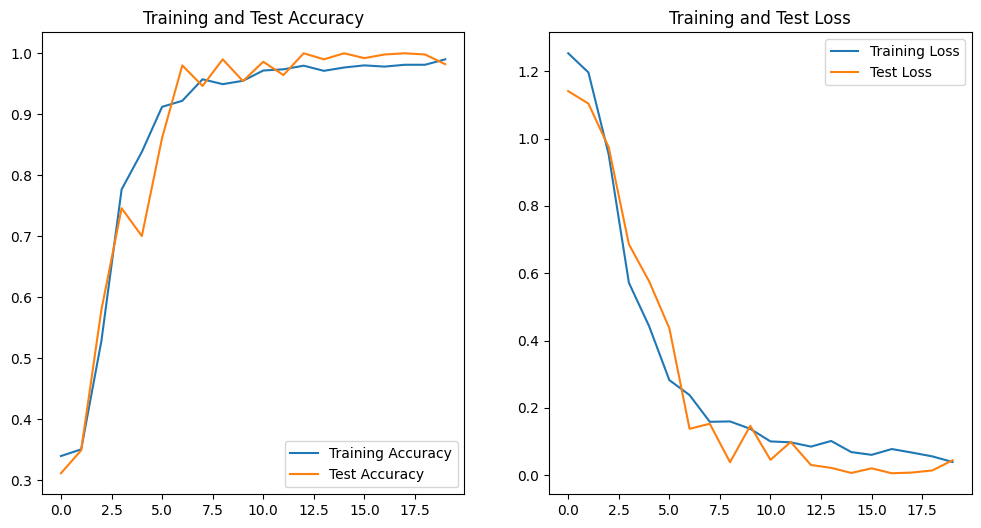

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9860 - loss: 0.0408
Accuracy for fold 5: 0.9821428656578064

Average accuracy for VGG across 5 folds: 0.9876984119415283



In [ ]:
# Set k-fold parameters
k = 5  # Number of folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_no = 1  # Counter to keep track of what fold

# Convert the dataset to numpy arrays
images = np.array([image for image, label in dataset['train']])
labels = np.array([label for image, label in dataset['train']])

# Loop over model types
for model_type in ['resnet', 'vgg']:
    print(f"\n=== Training {model_type.upper()} Model ===\n")

    fold_no = 1  # Reset fold counter for each model type
    test_scores = []  # Reset test scores for each model type

    # K-Fold Cross-Validation loop
    for train_index, val_index in kf.split(images):
        print(f"Training fold {fold_no}...")

        # Create the model based on the model_type
        if model_type == 'resnet':
            model = build_resnet(input_shape, num_classes, DROPOUT_RATE, BATCH_NORM)
        elif model_type == 'vgg':
            model = build_vgg(input_shape, num_classes, DROPOUT_RATE, BATCH_NORM)
        else:
            raise ValueError("Invalid model type! Use 'resnet' or 'vgg'.")

        # Train the model using the newly created model
        model, history = train_and_evaluate_model(
            model=model,  # Pass the model to be trained
            train_dataset=train_dataset,  # Defined earlier with augmentation
            test_dataset=test_dataset,  # Defined earlier
            learning_rate=LEARNING_RATE,
            epochs=20
        )

        # Evaluate the model on the validation set
        scores = model.evaluate(test_dataset)
        test_scores.append(scores[1])
        print(f"Accuracy for fold {fold_no}: {scores[1]}")
        fold_no += 1

    # Calculate and print the average accuracy for the current model
    average_accuracy = np.mean(test_scores)
    print(f"\nAverage accuracy for {model_type.upper()} across {k} folds: {average_accuracy}\n")


In [ ]:
# Function to evaluate both models, gets F1 score, AOC score and confusion matrix
def evaluate_model(model, test_dataset, class_names):


    y_true = []  # List to store true labels
    y_pred = []  # List to store predicted labels

    # Iterate over the test dataset to collect true and predicted labels
    for images, labels in test_dataset:
        y_true.extend(labels.numpy())  # Append true labels
        predictions = model.predict(images)
        y_pred.extend(np.argmax(predictions, axis=1))  # Append predicted labels

    # Convert lists to numpy arrays for compatibility with sklearn metrics
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate the F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')  # 'weighted' accounts for label imbalance
    print("F1 Score:", f1)

    # Calculate the ROC AUC score for multiclass using one-vs-rest approach
    try:
        # Get probabilities for each class
        y_prob = np.vstack([model.predict(images) for images, _ in test_dataset])
        roc_auc = roc_auc_score(y_true, y_prob, multi_class='ovr')  # 'ovr' = one-vs-rest
        print("ROC AUC Score:", roc_auc)
    except ValueError as e:
        print("Error calculating ROC AUC:", e)

    # Generate the confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", conf_matrix)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
F1 Score: 0.9900685732761282
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━

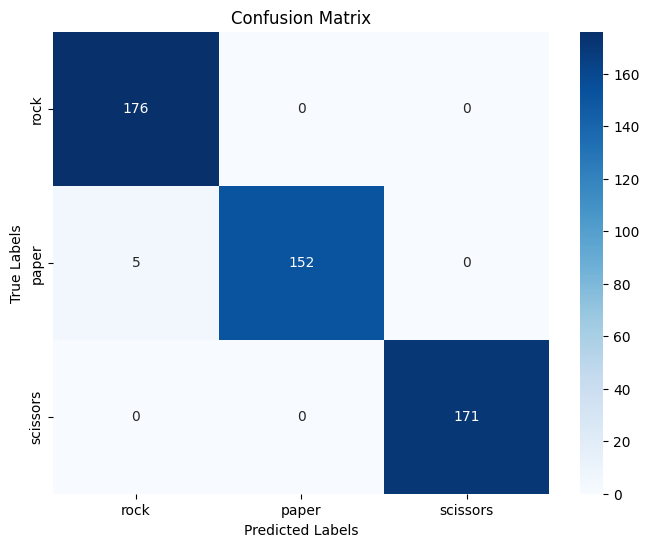

In [ ]:
# Evaluation for Resnet Model

evaluate_model(resnet_model, test_dataset, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
F1 Score: 1.0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━

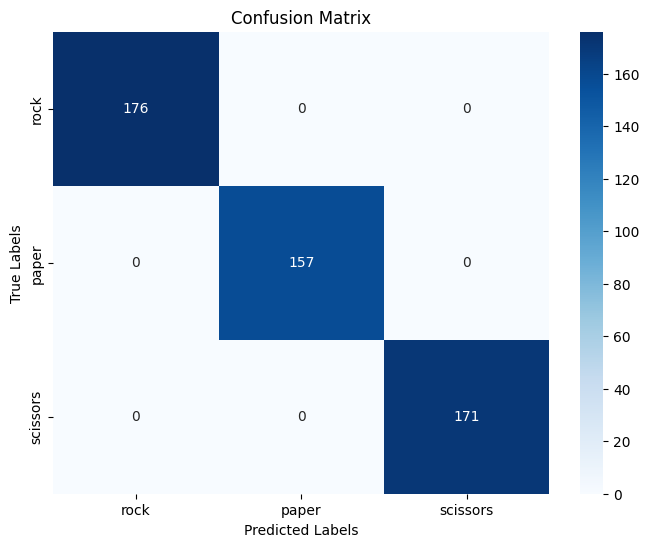

In [ ]:
# Evaluation for VGG model
evaluate_model(vgg_model, test_dataset, class_names)

Model: "ResNet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 32, 32, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 32)     │            896 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, 32, 32)     │          9,248 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 16, 16, 32)     │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 16, 32)     │              0 │ conv2d_3[0][0],        │
│                           │                        │                │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 16, 16, 32)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 16, 16, 32)     │          9,248 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16, 16, 32)     │              0 │ conv2d_5[0][0],        │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 16, 32)     │              0 │ add_1[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d  │ (None, 32)             │              0 │ activation_1[0][0]     │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 32)             │            128 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 3)              │             99 │ batch_normalization[0… │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 47,363 (185.01 KB)

 Trainable params: 47,299 (184.76 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 13s 133ms/step - accuracy: 0.4001 - loss: 2.0560 - val_accuracy: 0.3115 - val_loss: 1.8568
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 159ms/step - accuracy: 0.3293 - loss: 1.1294 - val_accuracy: 0.3115 - val_loss: 1.2608
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 153ms/step - accuracy: 0.3349 - loss: 1.1108 - val_accuracy: 0.4306 - val_loss: 1.0962
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step - accuracy: 0.3404 - loss: 1.1066 - val_accuracy: 0.3492 - val_loss: 1.0980
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - accuracy: 0.3346 - loss: 1.1044 - val_accuracy: 0.3393 - val_loss: 1.1003
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 157ms/step - accuracy: 0.3280 - loss: 1.1025 - val_accuracy: 0.3492 - val_loss: 1.0972
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 137ms/step - accuracy: 0.3187 - loss: 1.1033 - val_accuracy: 0.3492 - val_loss: 1.1002
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - accuracy: 0.3632 - loss: 1.1021 - val_accur

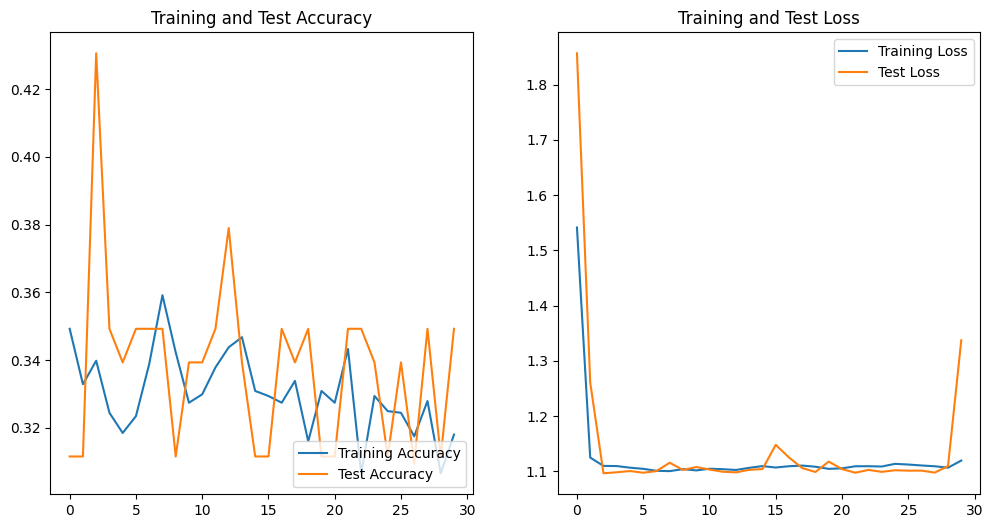

In [ ]:
# New HyperParameters (bad)
NEW_LEARNING_RATE = 0.05
NEW_DROPOUT_RATE = 0.7
NEW_BATCH_NORM = False
NEW_EPOCHS= 30

# ResNet
resnet_model_bad = build_resnet(
    input_shape,
    num_classes,
    DROPOUT_RATE,
    NEW_BATCH_NORM)


model, history = train_and_evaluate_model(
    resnet_model_bad,
    train_dataset,
    test_dataset,
    NEW_LEARNING_RATE,
    NEW_EPOCHS)

Model: "VGG"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 549,667 (2.10 MB)

 Trainable params: 549,667 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 551ms/step - accuracy: 0.3379 - loss: 35692.0820 - val_accuracy: 0.3492 - val_loss: 1.0995
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.3446 - loss: 1.1048 - val_accuracy: 0.3115 - val_loss: 1.1006
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 217ms/step - accuracy: 0.3261 - loss: 1.1019 - val_accuracy: 0.3393 - val_loss: 1.0986
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 218ms/step - accuracy: 0.3117 - loss: 1.1002 - val_accuracy: 0.3115 - val_loss: 1.1024
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step - accuracy: 0.3427 - loss: 1.0994 - val_accuracy: 0.3492 - val_loss: 1.1003
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 222ms/step - accuracy: 0.3199 - loss: 1.1014 - val_accuracy: 0.3393 - val_loss: 1.0982
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 220ms/step - accuracy: 0.3340 - loss: 1.1000 - val_accuracy: 0.3393 - val_loss: 1.0988
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 15s 221ms/step - accuracy: 0.3332 - loss: 1.1039 - val_

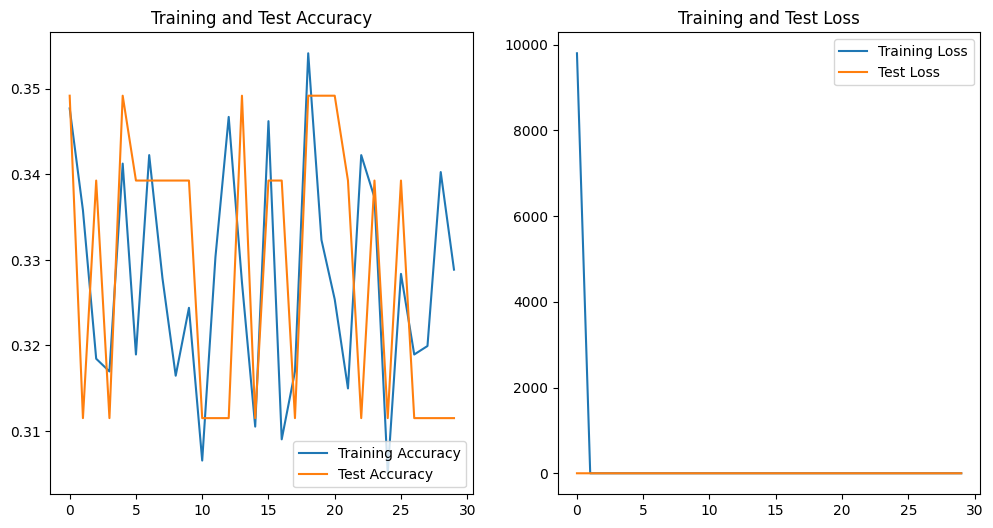

In [ ]:
# Vgg
vgg_model_bad = build_vgg(
    input_shape,
    num_classes,
    DROPOUT_RATE,
    NEW_BATCH_NORM)


model, history = train_and_evaluate_model(
    vgg_model_bad,
    train_dataset,
    test_dataset,
    NEW_LEARNING_RATE,
    NEW_EPOCHS)

In [ ]:
#
#
#
#
#
#

# The Data Set (4 marks)
We choose to use a rock paper scissors dataset from the tensor flow catalogue. We chose this dataset as we wanted to use image classification. It seemed to us that this dataset would allow us to work with images without being too complex.
## A. Visualisation of some of the key attributes
![Dataset Visualistion](https://drive.google.com/uc?export=view&id=180uM-L8mcVGZ4swCPoutsw9X7BUNqkbC)

Here is an example of the first 9 photos form the dataset. There are many key features in
1.	Variety In Appearance There are 3 key poses for each hand to aim for; rock, paper, scissors. However, as you can see in the above example there are many variations that can occur, a thumb can be out or in when performing scissors, a fist can be fully closed to curled at the fingers for rock and so on.

2.	Skin Tone There is a variety of skin tones that add variability to the data set.

3.	Balanced Class Distribution: This dataset has equal samples for each class of rock paper and scissors which shows there are no inherent biases. You can see this from photo below:
![Class Distribution](https://drive.google.com/uc?export=view&id=1ecEnzUnAQX-ckeOzZine5fT3TKR5bdYa)


## B. Data Correlation and feature engineering if applicable
![Brightness and Constrast](https://drive.google.com/uc?export=view&id=1UMFy3eTBgo3rUmPyJYIBKR5KevxmfvfK)

**BRIGTNESS AND CONTRAST:**


The two histograms above show the distribution of brightness and contrast across 100 sample images in the dataset. The Brightness Distribution represents the variation in mean pixel values across images, which indicates the overall lighting in each image. The Contrast Distribution represents the variation in pixel intensity differences, which affects how distinct edges are within an image.
These features are important to understand because variations in brightness and contrast may affect the performance of your model, and normalising these variations could help improve the model's ability to focus on meaningful patterns.

**EDGE DECTECTION:**

![Edge Paper](https://drive.google.com/uc?export=view&id=1KiuJj7LmFAZgBwbqVK8je-Nrdv1wwP6N)


![Edge Rock](https://drive.google.com/uc?export=view&id=1TZrgFnxukgcl1u_n8-ryBFfSPmIFpgc3)

![Edge Scissors](https://drive.google.com/uc?export=view&id=1wN419YRdpUFFQA4t-ecuKTKLwI78mmdk)

The Edge Detected Image (using the Canny Edge Detection) reveals the prominent edges in the sample images. It shows that the dataset contains complex edges, which suggests that the images have distinct and informative features. This supports the idea that the images in the dataset are not linearly separable, as they contain diverse features like shapes and outlines, which are not straightforward to classify using a simple linear model.


# C. Any pre-processing such as normalisation applied to the data

The next stage in the CNN was to pre-process and normalise the data. To accomplish this, we:
1.	Resized Images: The original dataset had images of various sizes which could introduce inconsistencies during training. By resizing all images to a consistent shape of (32, 32, 3), we ensured compatibility with our network's input layer and improved the training stability. This resizing step was achieved using the TensorFlow function tf.image.resize(), which allowed us to standardise the input size across the entire dataset.
2.	Normalised: After resizing we normalised the pixel values of the images to the range [0,1]. Originally, pixel values range from [0,255] and normalising these makes more suitable for training for CNN’s. This step helps stabilize the gradients during the backpropagation process and speeds up the convergence of the model. The normalisation was performed by dividing each pixel value by 255.0.

```python
# Setting dimensions for images
img_rows, img_cols = 32, 32
input_shape = (img_rows, img_cols, 3)  # Using RGB images as input

# Define the preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, (img_rows, img_cols))  
    image = image / 255.0
    return image, label
```
3.	Split the Dataset: The dataset was split into training and test sets in an 80-20 ratio. We used TensorFlow operations.take() and operations.skip() to create non-overlapping training and test datasets. Specifically:
•	The training set comprised 80% of the dataset, used to train the model and optimise its parameters.
•	The test set consisted of the remaining 20%, used to evaluate the model's performance on unseen data and help identify any overfitting or underfitting issues.

This split ensures that the model is exposed to unseen data during the training process, allowing for a more reliable evaluation of its generalisation capabilities.

```python
# Splitting the dataset into training and test sets
train_size= int(0.8 * dataset['train'].cardinality().numpy())
```

4. Data Augmentation: We initally didn't have data augmentation included but noticed our model was overfitting. Data augmentation introduces variability into the dataset and helped our model generalise better when training. We introudced random fliping, colour manipulations, rotating images and random zooming. Here is a preview of what our dataset looked like after this

![Data Augmentation](https://drive.google.com/uc?export=view&id=1SEzpsb2HiKyi3IP8auFrEsy7t5SGOdT8)

We only randomly augment the training dataset, not test. This is to help our model generalise better and our test set must represent the raw dataset. We also batch the data into groups of 32 samples to allow our model to process multiple samples at once. We also shuffle the dataset with buffer size of 1000 so the data fed into model is not predictable
```python
train_dataset = (
    dataset['train'].take(train_size)
    .map(preprocess)         
    .map(augment_data)        
    .batch(32)
    .shuffle(buffer_size=1000)
)
```




In [ ]:
#
#
#
#
#
#

# The Network Structures and Hyper Parameters (6 Marks)
## a. Diagram of the two network architectures
**ResNet**
![Resnet Architecture Diagram](https://drive.google.com/uc?export=view&id=19NaZvX5i47AyGILwiSlETwm_xcVgk5bF)

**VGG**  
![VGG Architecture Diagram](https://drive.google.com/uc?export=view&id=1CFQBjdkVi5x_4gV-exJ69AhOLfr3EMxy)




## B. Describe weight initialisation, activation function, batch normalisation, regularisation, hyperparameters, transfer learning if leveraged, and more. For example, if opting for ResNet, a few paragraphs on Residual learning is necessary given that this is a distinguishing feature.

**RESNET**

The CNN architecture we decided to go with was ResNet. Residual learning is the defining feature of ResNet and addresses the problem of vanishing gradients, which limits training deep networks. The key insight of residual learning is to create shortcut connections that bypass a few layers. Instead of learning an explicit mapping, residual blocks allow the model to learn the residuals (i.e., differences between the input and output). This makes it easier for the network to propagate gradients during backpropagation, and thus it can train deeper architectures without the risk of vanishing gradients

Initial Convolutional Block
```python
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(32, (3, 3), padding='same',
activation='relu')(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
```

-	Convolutional layers with 32 filters of size (3, 3) and a ReLU activation. These layers help in feature extraction by learning spatial hierarchies of features from the input image, in our case person performing a ‘rock’, ‘paper’ or ‘scissor’ action with their hand. The use of “padding= ‘same’” ensures that the spatial dimensions of the output are the same as the input.

-	MaxPooling Layer reduces the spatial dimensions of the feature maps, which helps reduce computational complexity and makes the model more efficient. It works by selecting the most prominent feature, making the model invariant to small translations of the image
Residual Block
```python
for _ in range(2):
        residual = x
        x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
        x = layers.Add()([x, residual])
        x = layers.Activation('relu')(x)
```
-	Residual is a shortcut connection that preserves the original input (x) and adds it back to the output after two convolutional layers. The line x = layers.Add()([x, residual]) combines the original input with the transformed output, allowing the network to learn the difference (residual) between the input and the output, rather than the full transformation. This helps in training deeper networks by making it easier for gradients to flow through the layers, improving learning stability and speed.


**Global Average Pooling (GAP)**
```python
x = layers.GlobalAveragePooling2D()(x)
```
This layer replaces fully connected layers by computing the average of each feature map. GAP helps reduce the number of parameters, which in turn helps prevent overfitting. Unlike fully connected layers, GAP retains the spatial essence of the feature maps, which helps the model generalise better.


**Fully Connected Layers**
```python
x = layers.Dropout(dropout_rate)(x)
if batch_norm:
    x = layers.BatchNormalization()(x)
```
-	**Dropout** was used to prevent overfitting by randomly setting a fraction (dropout_rate, which we set to 0.5) of the input units to zero during training. This forces the network to be more robust and helps prevent it from relying too heavily on a particular feature.


-	**Batch Normalisation** works by normalising the output of a layer to have a mean of zero and variance of one, using the current batch's statistics. It then scales and shifts these normalised values with learnable parameters to maintain the network's ability to learn.


**Activation function**
ReLU (Rectified Linear Unit) activation function we used sets all negative values to zero and keeps positive values unchanged, helping the network learn complex patterns by introducing non-linearity. ReLU is used to prevent negative values from passing through, which helps in speeding up convergence and avoiding issues like the vanishing gradient problem, assisting ResNet.

<br>**VGG**

The second CNN architecture we decided to go with is based on the VGG(Visual Geometry Group) model, which is known for its effectiveness in image classification, object detection, and image segmentation tasks. The original VGG network is known for its depth and complexity, but we scaled it down to work better with our dataset. Unlike ResNet, which uses residual connections, the VGG architecture relies on a straightforward sequential stacking of convolutional layers to extract features. The VGG architecture is characterised by its use of small 3 x 3 convolutional filters stacked sequentially, followed by max-pooling layers and then fully connected layers.

**Initial Convolutional Layers**
```python
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(inputs)
x = layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
```

- In the initial convolutional block, we start with 32 filters of size 3×3 with ReLU activation similarly to Resnet. However, unlike ResNet's focus on deeper layers and residual connections, VGG focuses on deeper sequential layers without shortcuts. By using a smaller number of filters, we reduce the model's computational complexity, which is more appropriate for the smaller input size of 32×32. The use of "padding='same'" ensures that the spatial dimensions are preserved, allowing the model to effectively learn patterns specific to Rock, Paper, Scissors gestures.

- MaxPooling is applied to reduce the spatial dimensions by half, decreasing computational load while preserving the most important features, making the model more efficient and invariant to small translations.

**Stacked Convolutional Layers**

After the initial block, we progressively increase the number of filters in the next few blocks:
```python
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
```

- Each block doubles the number of filters (from 32 to 64, to 128), allowing the model to learn more complex features as it goes deeper. VGG relies on progressively increasing the depth and filter count to capture higher-level abstractions. This approach allows VGG to build complexity in a more straightforward, layer-by-layer way. The max-pooling layers further reduce the spatial dimensions.


**Flatten and Fully Connected Layers**
```python
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(dropout_rate)(x)
if batch_norm:
    x = layers.BatchNormalization()(x)

outputs = layers.Dense(num_classes, activation='softmax')(x)
```
- The Flatten layer converts the 4D input into a 2D vector, which is then passed through a dense layer with 128 units. The dense layer uses ReLU activation to allow the model to learn complex patterns more effectively Similar to the fully connected layers in ResNet, we aim to capture complex combinations of high-level features. However, unlike ResNet’s use of global average pooling to reduce the dimensionality and prevent overfitting, VGG relies on fully connected dense layers to capture patterns, which often results in a larger number of parameters.

- Similarly to Resnet, we apply Dropout with a rate of 0.5 to further prevent overfitting by randomly setting a fraction of the input units to zero. Batch Normalization is also included to stabilise and speed up training.

- The final softmax layer outputs class probabilities for the three categories: Rock, Paper, Scissors.


<br>**Hyperparameters**
- **Input Shape: (32, 32, 3)**

Represents an RGB image with a height and width of 32 pixels each.
- Number of Classes: 3
As we had Rock, Paper, scissors

- **Learning Rate: 0.001**

We initially set to a learning rate of 0.001 as we use Adam as our optimiser, which adapts the learning rate for each parameter dynamically


Training the model for 15 epochs was a choice made to strike a balance between training time and model performance. Early stopping and other evaluation metrics were used to ensure the model did not overfit while achieving good performance metrics.

**Weight Initlisation**
Each Conv2D layer has weughts initalised by keras which by defauly uses He Initalisation. This works by setting the weights to values drawn from a distribution with a variance that depends on number of input nerouns. The Dense layer with keras uses Xavier Initialisation for weights by default. It draws the weights from a uniform distribution with a specific range, designed to keep the variance of activations stable across layers.




In [ ]:
#
#
#
#
#
#

# The Cost / Loss / Error / Objective function (2 marks)
We used sparse_categorical_crossentropy as the loss function. This is a common choice for multi-class classification problems where the labels are integers representing different categories (like 0 for rock, 1 for paper, and 2 for scissors).
Here are some of the reasons we chose sparse_categorical_crossentropy:


- **Suitable for Multi-Class:** It's designed for situations with more than two classes, unlike for example, binary cross-entropy ( which we used in our MLP assignment for predicting if someone was mentally fatigued or not). Sparse categorical cross-entropy is designed to handle problems which involve more than two classes, and our problem had 3 classes

- **Integer Labels:** Our dataset uses integer labels, which align with how this function expects the target values.

- **Probability Distribution:** It calculates the difference between the predicted probability distribution (output of softmax) and the true class label, guiding the model towards accurate predictions as it provides a more clear objective for our multi class output.


In [ ]:
#
#
#
#
#
#

# The Optimiser (2 marks).
We used the Adam optimiser. Adam (Adaptive Moment Estimation) is a popular optimisation algorithm in deep learning. We were familiar with this from the last assignment and opted to use it again.
We like it as it automatically adjusts learning rates for each parameter, making it efficient. It also incorporates momentum, which helps accelerate learning and navigate flat areas in the loss landscape.


In [ ]:
#
#
#
#
#
#

# Cross Fold Validation (2 marks)
We chose to use 5 folds using 20 epochs. We felt that this would give us an accurate representation of the model without drastically stretching the runtime. This technique spilts dataset into 5 folds and provides a robust evalution of both models bu testing it on different subsets of data to ensure in generlaises well and can compare to our 80:20 test train split. It helps mitigate overfitting and allows for a comparision between but models under consistent conditions.

We had to convert the images and lbels from our dataset into numpy arrays
```python
images = np.array([image for image, label in dataset['train']])
labels = np.array([label for image, label in dataset['train']])
```

We had to do this to make our data compatible with the K fold splitting process which uses numpys arrays

We also used a for loop to ensure we tested both models for 5 folds
```python
# Loop over model types
for model_type in ['resnet', 'vgg']:
    print(f"\n=== Training {model_type.upper()} Model ===\n")

    fold_no = 1  # Reset fold counter for each model type
    test_scores = []  # Reset test scores for each model type

    # K-Fold Cross-Validation loop
    for train_index, val_index in kf.split(images):
        print(f"Training fold {fold_no}...")

        # Create the model based on the model_type
        if model_type == 'resnet':
            model = build_resnet(input_shape, num_classes, DROPOUT_RATE, BATCH_NORM)
        elif model_type == 'vgg':
            model = build_vgg(input_shape, num_classes, DROPOUT_RATE, BATCH_NORM)
        else:
            raise ValueError("Invalid model type! Use 'resnet' or 'vgg'.")
  ```

We then iterate over each fold
```python
for train_index, val_index in kf.split(images):
```
and initalise a new moel for each fold
```python
    model, history = train_and_evaluate_model(
        model,  # Pass the model to be trained
        train_dataset, # Defined earlier with augmentation
        test_dataset, # Defined earlier
        learning_rate=LEARNING_RATE, # LR for Adam
        epochs=20 # epochs
    )

```
initalising a new model for each fold is very important as the model can start trianing from scratch fot each fold. Any learned weights from previous folds therefore have no impact, K cross fold is a good guide as it trians and test on different subsets of the data



## Images of Results
### ResNet
![K fold 1](https://drive.google.com/uc?export=view&id=12EeZagCrhy9wu9ai-UIKiyRK2UAZa0Eu)
Accuracy for fold 1: 0.9563491940498352



![K fold 2](https://drive.google.com/uc?export=view&id=1SvsOtvTikIPYVwJtTSX-blF26l_H4KlB)
Accuracy for fold 2: 0.8809523582458496


![K fold 3](https://drive.google.com/uc?export=view&id=1vZJUfFApTqOJPWsIXWfRzJ0nXufPirXe)
Accuracy for fold 3: 0.8095238208770752



![K fold 4](https://drive.google.com/uc?export=view&id=1a1AtmG8ekr-HMXNQ-GIcHF-G4-fq9RXN)
Accuracy for fold 4: 0.920634925365448


![K fold 5](https://drive.google.com/uc?export=view&id=1tKt0TrQ2jWJDXh3d_Enl_S5Jpn6cNMil)
Accuracy for fold 5: 0.9702380895614624



Average accuracy for RESNET across 5 folds: 0.907539677619934

### VGG
![K fold 1 VGG](https://drive.google.com/uc?export=view&id=1nYmqmS7MEUFe04dTzN_Os_Ev-JviYdN1)
Accuracy for fold 1: 1.0


![K fold 2 VGG](https://drive.google.com/uc?export=view&id=1RBA5lDqTNs4nJ3Koywzdv8mo1h-XCVgL)
Accuracy for fold 2: 0.9801587462425232


![K fold 3 VGG](https://drive.google.com/uc?export=view&id=1Dr4K8J-rUUTXnq-rG29NrvBFf7jC2Jqo)
Accuracy for fold 3: 0.9920634627342224

![K fold 4 VGG](https://drive.google.com/uc?export=view&id=1Dr4K8J-rUUTXnq-rG29NrvBFf7jC2Jqo)
Accuracy for fold 4: 0.9841269850730896

![K fold 5 VGG](https://drive.google.com/uc?export=view&id=1tKt0TrQ2jWJDXh3d_Enl_S5Jpn6cNMil)
Accuracy for fold 5: 0.9821428656578064

Average accuracy for VGG across 5 folds: 0.9876984119415283


Resnet achieved accuracies from 80% to 97%. This variability could suggest the model maybe sensitive to specfic training/test split. Fold 3 had a lower accuracy highlighting this. However, overall it demonstrated strong generlisation with an average accuracy of 90.75%


VGG outperformed resnet, achieving near perfect accuracy in multiple folds. It acheived an average accuracy of 98.77%. It's performance was more consistent across the folds compared to ResNet, suggesting it is better suited to our dataset and less effected by the training/test split. This high accuracy also shows VGGs ability to generalise better than ResNet, which is due to its simpler acrhitecture



In [ ]:
#
#
#
#
#
#

# Results (4 marks).
# Evaluation of the results (5 marks)

### Resnet



![ResNet 100 epochs](https://drive.google.com/uc?export=view&id=1yDjxKFABWjJkkkEvxYcjrqtDc1xktFLm)

![Confusion Matrix resnet](https://drive.google.com/uc?export=view&id=1XDVVJLnmFfrukAv0TrqPNrKzebY4aTLM)


![ROC resnet](https://drive.google.com/uc?export=view&id=1dEFRtt_mJ6KLOVOTd3WWodVxDaM13jRm)

### VGG

![VGG 100 epochs](https://drive.google.com/uc?export=view&id=11Qu_611HMgkECqSzIza5ffhoxJiHDSGd)

![Confusion Matrix VGG](https://drive.google.com/uc?export=view&id=1GlsSjG-9lQcFLLcr_rjgDKnpgoDaTEpj)


![ROC VGG](https://drive.google.com/uc?export=view&id=1JOWf8kpaUMWUujMadKizKq7_21t7V6xB)

### Calculations from Confusion Matrix

Based of our confusion matrix for both ResNet and VGG:

TP = True Positive, FP = False Positive, FN = False Negative, TN = True Negative


Formula For Percision:
TP/ (TP + FP)

Formula for Recall
TP/ (TP + FN)

#### ResNet calculations
Percision for Rock:
176 / (176 + 0) = 1


Percision for Paper:
152/ (152 + 5) = 0.9682


Percision for Scirrors:
171 / (171 + 0) = 1



Recall for Rock:
176/ (176 + 0)= 1


Recall for Paper:
152/ (152+ 5)= 0.9682



Recall for scissors:
171/ ( 171 + 0) = 1

| Class     | TP  | TN  | FP  | FN  | Precision | Recall  |
|-----------|-----|-----|-----|-----|-----------|---------|
| Rock      | 176 | 328 | 0   | 0   | 1.00      | 1.00    |
| Paper     | 152 | 347 | 5   | 0   | 0.9682    | 0.9682  |
| Scissors  | 171 | 333 | 0   | 0   | 1.00      | 1.00    |


#### VGG calculations
Percision for Rock:
176 / (176 + 0) = 1


Percision for Paper:
157/ (157 + 0) = 1


Percision for Scirrors:
171 / (171 + 0) = 1



Recall for Rock:
176/ (176 + 0)= 1


Recall for Paper:
157/ (157 + 0)= 0



Recall for scissors:
171/ ( 171 + 0) = 1

| Class     | TP  | TN  | FP  | FN  | Precision | Recall  |
|-----------|-----|-----|-----|-----|-----------|---------|
| Rock      | 176 | 328 | 0   | 0   | 1.00      | 1.00    |
| Paper     | 152 | 347 | 0   | 0   | 1.00      | 1.00    |
| Scissors  | 171 | 333 | 0   | 0   | 1.00      | 1.00    |



## Justifcation Of metrics

1. Training and Test Accuracy
- Accuracy gives a very clear understanding on how well the model is performing and it gave us a good indication of how well the model was performing while it was training

2. Traing and Test loss
- Loss was a required section in the assignment and it is very useful in understanding how well our models predictions are in terms of saying if a particular hand action was performing a rock action, for example. Loss gives good insights into the moels confidence with its predictions

3. Confusion Matrix
- This provides detailed insights into the models performance across all classes and how well it distinguishes between the 3 different actions

4. F1- Score
-  We used this as it was breifly mentioned in the lecutres. Not as useful for our dataset as no class imbalance

5. ROC AUC Score
- Mainly used for binary classifcation, but we used it in a one vs rest approach to show models ability to distinguish between classes. It was also pointed out as one to use in the lectures.

6. Percision and Recall
- We wanted to show that the models are not only classifying correctly but also that they are not producing False Positives or Negatives.


## Evaluation of Results

### ResNet

1. Training and test accuracy
- The graph shows model performs well on both training and test datasets. It has high trianing and test accuracy and is not overfitting and indicating that it is learning effectivly. The accuracies are also close together that demonstrates it is performing reliably across the whole dataset

2. Training and test loss
- The graph shows a steady decrease, indicating our models predictions are improving over the training process. It drops quickly at the start as our model is learning very well early on.

3. Confusion Matrix
The confusion matrix provides a clear visualisation of our model's performance across all classes. The True Positives are significantly higher compared to other valuess, which shows our model is highly accurate.
Misclassifications are minimal, with only a few cases where Rock was incorrectly predicted.

4. We achieved an F1 score of 0.9721932893840124 which indicates our model balances precision and recall well

5. ROC AUC score
- We acheived a score of 0.999, showing again our model is highly effective in separating the classes.

6. Percision and Recall
- Our model has rarely any false positives or negatives. Percision is very high with Rock achieving 1, paper 0.9682, and scirrors 1,00. Recall is also strong with Rock achieving the same results as percision

### VGG

1. Training and test accuracy
- The graph shows model performs well on both training and test datasets. It has high trianing and test accuracy and is not overfitting and indicating that it is learning effectivly. The accuracies are also close together that demonstrates it is performing reliably across the whole dataset

2. Training and test loss
- The graph shows a steady decrease, indicating our models predictions are improving over the training process. It drops quickly at the start as our model is learning very well early on.

3. Confusion Matrix
The confusion matrix provides a clear visualisation of our model's performance across all classes. The True Positives are significantly higher compared to other valuess, which shows our model is highly accurate.
Misclassifications are minimal, with only a few cases where Rock was incorrectly predicted.

4. We achieved an F1 score of 1.0 which indicates our model balances precision and recall well

5. ROC AUC score
- We acheived a score of 1.0, showing again our model is highly effective in separating the classes.

6. Percision and Recall
- Our model has no any false positives or negatives. Percision and recall have a score of 1 for all

### ResNet vs VGG
1. Training and Test Accuracy   
Both ResNet and VGG output high training and test accuracy, showing they perform well on their respective datasets. However, VGG slightly outperforms ResNet by achieving perfect accuracy (1.0) on both training and test datasets, while ResNet shows a marginal gap. This suggests that VGG might have learned the small dataset more comprehensively but both models are effective and not overfitting.     

2. Training and Test Loss   
The training and test loss for both models decrease. VGG’s final loss values are likely closer to zero compared to ResNet, corresponding to its perfect accuracy giving it a slight edge in terms of minimizing errors.    

3. Confusion Matrix   
Both models produce highly accurate predictions with minimal misclassifications. ResNet has a few misclassifications mainly where Rock was incorrectly predicted. VGG again gets a perfect confusion matrix with no misclassifications. This demonstrates that VGG achieves superior class separation and prediction reliability compared to ResNet.   

4. F1 Score   
ResNet achieves a strong F1 score of 0.972, indicating it balances precision and recall well. However VGG gets a perfect F1 score of 1.0, reflecting flawless performance across all metrics. This demonstrates VGG’s superior ability to avoid trade-offs between precision and recall.   

5. ROC AUC Score   
Both models achieve near-perfect ROC AUC scores, with ResNet scoring 0.999 and VGG achieving 1.0. The difference here is inserparable.   

6. Precision and Recall   
ResNet achieves high precision and recall, with minimal false positives and negatives, particularly excelling in the Rock and Scissors classes. VGG achieves perfection in both metrics across all classes with no false positives or negatives.   

Summation of the Comparison   
VGG emerges as the better model in this comparison. Its perfect accuracy, loss minimization, confusion matrix, F1 score, ROC AUC score, and precision-recall metrics highlight its superior performance. The deeper architecture of VGG might better capture the nuances of the dataset, making it more effective in separating classes without errors. However, the slight advantage of VGG might come at the cost of higher computational demands.





In [ ]:
#
#
#
#
#
#

# Varying HyperParameters

We are also including this as its mentioned at top of assingment. Wasn't included as section for marks but feel like we should explore

We set new hyperparameters
```python
# Ney Hyperparameters (bad)
NEW_LEARNING_RATE = 0.05
NEW_DROPOUT_RATE = 0.7
NEW_BATCH_NORM = False
NEW_EPOCHS= 30

# ResNet
resnet_model_bad = build_resnet(
    input_shape,
    num_classes,
    DROPOUT_RATE,
    NEW_BATCH_NORM)


model, history = train_and_evaluate_model(
    resnet_model,
    train_dataset,
    test_dataset,
    NEW_LEARNING_RATE,
    NEW_EPOCHS)

# Vgg
vgg_model_bad = build_vgg(
    input_shape,
    num_classes,
    DROPOUT_RATE,
    NEW_BATCH_NORM)


model, history = train_and_evaluate_model(
    vgg_model_bad,
    train_dataset,
    test_dataset,
    NEW_LEARNING_RATE,
    NEW_EPOCHS)
```
###  Resnet
![ResNet Varied Hyperparameters](https://drive.google.com/uc?export=view&id=15SQBUlNrHBrSs3ln2rrpiXuFc5Zuxc6N)

###  VGG
![ResNet Varied Hyperparameters](https://drive.google.com/uc?export=view&id=1c_EYQhM6OyogqKNnqddER-FkgTRKaxEt)


**Impact of Adjusted Hyperparameters**
Learning Rate (0.05): Setting this high of a learning rate caused both models to struggle, as you can see by the consistently low accuracy values (ranging rougly from 0.28 to 0.40 for both models). Instead of showing steady improvement, the accuracy fluctuates erratically. This indicates that the high learning rate prevented the models from finding an optimal solution. Using a lower learning rates shown success earlier providing a more stable and gradual improvement in accuracy. The high rate used here led to divergence and unstable training behavior.

Dropout Rate (0.7): A dropout rate of 70% means most of the neurons are deactivated during each training step. Dropout helps prevent overfitting but this high value severely impacted both models ability to learn meaningful patterns from the data. For instance, the ResNet graph shows irregular accuracy trends, and the model struggles to generalise effectively. The VGG model was even more affected, evident from some flat orange test accuracy lines which indicates no learning.

Batch Normalisation (Disabled): Batch normalisation stabilises the learning process by normalising layer inputs. Disabling it leads to inconsistent layer inputs, causing greater variance in model performance. This is reflected in the increased variability of the ResNet accuracy and loss plots. For the VGG model, disabling batch normalization and other aggressive settings led to an inability to make meaningful updates to the weights, resulting in no improvement in test performance.

Lower Epochs (30): We reduced the number of training epochs to speed up the experiments. With such weak hyperparameters, increasing epochs would not have helped as both models already failed to learn effectively.

# References

- https://docs.opencv.org/3.4/da/d22/tutorial_py_canny.html

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html


- https://www.tensorflow.org/guide/data


- ResNet https://towardsdatascience.com/understanding-and-coding-a-resnet-in-keras-446d7ff84d33

- VGG https://www.geeksforgeeks.org/vgg-16-cnn-model/
- https://thegrigorian.medium.com/understanding-vgg-neural-networks-architecture-and-implementation-400d99a9e9ba


- https://medium.com/@nanaliu/a-seamless-guide-to-embedding-photos-into-google-colab-894167bfde3a#:~:text=To%20insert%20the%20image%2C%20you%20can%20use%20the,in%20a%20Markdown%20cell%20in%20your%20Colab%20notebook%3A

-